# C5 文本聚类和主题建模

* 非结构化文本聚类
* 主题建模

In [40]:
# temp
#!pip install umap-learn
#!pip install hdbscan
#!pip install bertopic
!pip install datamapplot

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.8/584.8 kB 1.6 MB/s eta 0:00:00m-:--:--
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 4.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 17.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 20.7 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 25.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.0 MB/s eta 0:00:00
  Cre

In [17]:
import torch
from datasets import load_dataset
from rich import inspect
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import pipeline

%matplotlib inline

from util import init_torch_device

device = init_torch_device()

In [3]:
raw_dataset = load_dataset('maartengr/arxiv_nlp')

dataset = raw_dataset['train']
print(dataset)
#inspect(dataset)
abstracts = dataset['Abstracts']
titles = dataset['Titles']

Dataset({
    features: ['Titles', 'Abstracts', 'Years', 'Categories'],
    num_rows: 44949
})


## 文本聚类

### 通用流程

1. 嵌入模型，将文本转为文本嵌入
2. 降维模型，将嵌入向量降低至更低维度
3. 聚类模型，针对降维后的嵌入向量聚类

#### 嵌入

`n`篇文档通过嵌入模型转为`n * m`的嵌入向量矩阵，捕捉文本含义的数值表示

因此需要使用对语义相似度任务作专门优化的模型

#### 降维

* 主成分分析 PCA
* 统一流形逼近和投影（Uniform Manifold Approximation and Projection, UMAP）

#### 聚类

* k-means：在有预设簇的情况下，可以使用 k 均值聚类
* 基于密度算法聚类：可以在没有预设的情况下计算簇的数量，且不强制所有数据点属于某个簇
  * HDBSCAN（Hierarchical Density-Based Spatial Clustering of Applications with Noise，具有噪声的分层密度空间聚类）


In [5]:
embedding_model = SentenceTransformer('thenlper/gte-small')
embeddings = embedding_model.encode(abstracts, show_progress_bar=True, device=device)

Batches:   0%|          | 0/1405 [00:00<?, ?it/s]

In [6]:
print(len(abstracts))
print(embeddings.shape)

44949
(44949, 384)


In [7]:
umap_model = UMAP(
    n_components=5,
    min_dist=0.0,
    metric='cosine',
    random_state=42,
)

reduced_embeddings = umap_model.fit_transform(embeddings)
print(reduced_embeddings.shape)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(44949, 5)


In [8]:
from hdbscan import HDBSCAN

hdbscan_model = HDBSCAN(
    min_cluster_size=50,
    metric='euclidean',
    cluster_selection_method='eom',
).fit(reduced_embeddings)

# inspect(hdbscan_model)

clusters = hdbscan_model.labels_
print(len(set(clusters)))

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tok

151


In [9]:
cluster = 0

for idx in np.where(clusters==cluster)[0][:3]:
    print(abstracts[idx][:300] + '...\n')

  This works aims to design a statistical machine translation from English text
to American Sign Language (ASL). The system is based on Moses tool with some
modifications and the results are synthesized through a 3D avatar for
interpretation. First, we translate the input text to gloss, a written fo...

  Researches on signed languages still strongly dissociate lin- guistic issues
related on phonological and phonetic aspects, and gesture studies for
recognition and synthesis purposes. This paper focuses on the imbrication of
motion and meaning for the analysis, synthesis and evaluation of sign lang...

  Modern computational linguistic software cannot produce important aspects of
sign language translation. Using some researches we deduce that the majority of
automatic sign language translation systems ignore many aspects when they
generate animation; therefore the interpretation lost the truth inf...



In [10]:
reduced_embeddings = UMAP(
    n_components=2,
    min_dist=0.0,
    metric='cosine',
    random_state=42,
).fit_transform(embeddings)

df = pd.DataFrame(reduced_embeddings, columns=['x', 'y'])
df['title'] = titles
df['cluster'] = [str(c) for c in clusters]

clusters_df = df.loc[df.cluster != '-1', :]
outliers_df = df.loc[df.cluster == '-1', :]

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(np.float64(-7.719907307624817),
 np.float64(11.273350739479065),
 np.float64(-6.401226210594177),
 np.float64(11.249586749076844))

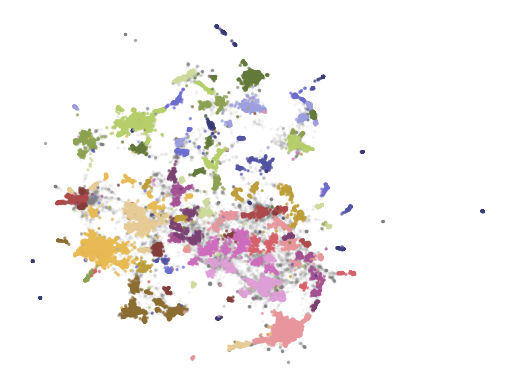

In [11]:
plt.scatter(
    outliers_df.x, outliers_df.y, alpha=0.05, s=2, c='gray'
)
plt.scatter(
    clusters_df.x, clusters_df.y, alpha=0.6, s=2, c=clusters_df.cluster.astype(int),
    cmap='tab20b'
)
plt.axis('off')

## 主题建模

目的：找到一组最能代表、捕捉主题含义的关键词或短语

框架：`BERTopic` 模块化主题建模框架

### BERTopic 步骤：

1. 聚类：嵌入、降维、聚类
2. 主题表示：经典词袋法，对词表中的词在语料库中的分布建模：
   * 基于簇级别的词频
   * 基于类的词频-逆文档频率（c-TF-IDF）

### 特点

* 模块化：嵌入、降维、聚类、创建词袋和词加权，都可以定制模型和算法
* 添加`表示模型`做微调处理，例如：重排期优化主题，

### 表示模型

|模型|目的|原理|优点|缺点|
|---|---|---|---|---|
|KeyBERTInspired|KeyBERT 启发：计算、比较嵌入和文档的余弦相似度来提取文本中的关键字|计算文档的 c-TF-IDF 值与对应主题的相似度|考虑词的语义结构|1. 一些有意义的缩写被删除；2. 存在冗余|
|MMR(maximal marginal relevant) 最大边际相关性|找到一组相互之间具有差异性，但仍然与所比较的文档相关的关键词|嵌入一组候选关键词，并迭代计算下一个最佳关键词|更小但多样化的关键词集；去除冗余|没有解决词袋未考虑语义结构的问题|

### 生成模型

利用生成模型（LLM）和提示工程，为创建的主题，生成标签



In [12]:
from bertopic import BERTopic

topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True
).fit(abstracts, embeddings)

topic_model.get_topic_info()

2025-06-03 10:17:31,024 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-03 10:17:48,124 - BERTopic - Dimensionality - Completed ✓
2025-06-03 10:17:48,125 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-03 10:17:48,636 - BERTopic - Cluster - Completed ✓
2025-06-03 10:17:48,640 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-03 10:17:49,954 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,-1,13800,-1_the_of_and_to,"[the, of, and, to, in, we, for, that, language...",[ Sentiment analysis is one of the well-known...
1,0,2250,0_question_questions_answer_qa,"[question, questions, answer, qa, answering, a...",[ Answer retrieval is to find the most aligne...
2,1,2060,1_speech_asr_recognition_end,"[speech, asr, recognition, end, acoustic, spea...",[ The speech chain mechanism integrates autom...
3,2,1413,2_medical_clinical_biomedical_patient,"[medical, clinical, biomedical, patient, notes...",[ Healthcare is becoming a more and more impo...
4,3,914,3_summarization_summaries_summary_abstractive,"[summarization, summaries, summary, abstractiv...",[ Abstractive summarization systems generally...
...,...,...,...,...,...
146,145,55,145_prompt_prompts_prompting_optimization,"[prompt, prompts, prompting, optimization, llm...",[ Prompt optimization aims to find the best p...
147,146,54,146_sentence_embeddings_sts_similarity,"[sentence, embeddings, sts, similarity, embedd...",[ Sentence representation at the semantic lev...
148,147,54,147_counseling_mental_therapy_health,"[counseling, mental, therapy, health, psychoth...",[ Mental health care poses an increasingly se...
149,148,52,148_gans_gan_adversarial_generation,"[gans, gan, adversarial, generation, generativ...",[ Text generation is of particular interest i...


In [ ]:
topic_model.get_topic(1)

In [ ]:
topic_model.find_topics('topic modeling')

In [ ]:
topic_model.get_topic(27)

In [ ]:
topic_model.topics_[titles.index('BERTopic: Neural topic modeling with a class-based TF-IDF procedure')]

In [ ]:
fig = topic_model.visualize_documents(
    titles,
    reduced_embeddings=reduced_embeddings,
    width=1200,
    hide_annotations=True
)

fig.update_layout(font=dict(size=16))

In [ ]:
topic_model.visualize_barchart()

In [ ]:
topic_model.visualize_heatmap(n_clusters=30)

In [ ]:
topic_model.visualize_hierarchy()

In [ ]:
ids = topic_model.find_topics('game')
print(ids)

for i in ids[0]:
    if i == -1:
        break
    print(topic_model.get_topic(i))

In [13]:
from copy import deepcopy


original_topics = deepcopy(topic_model.topic_representations_)

In [14]:
def topic_differences(model, original_topics, nr_topics=5):
    df = pd.DataFrame(columns=['Topic', 'Original', 'Updated'])
    for topic in range(nr_topics):
        og_words = ' | '.join(list(zip(*original_topics[topic]))[0][:5])
        new_words = ' | '.join(list(zip(*model.get_topic(topic)))[0][:5])
        df.loc[len(df)] = [topic, og_words, new_words]

    return df


In [15]:
# KeyBERT: 计算、比较嵌入和文档的余弦相似度来提取文本中的关键字
# 缺点：一些关键的缩写被删除
from bertopic.representation import KeyBERTInspired


representation_model = KeyBERTInspired()
topic_model.update_topics(abstracts, representation_model=representation_model)

topic_differences(topic_model, original_topics)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

invalid value encountered in matmul



,Topic,Original,Updated
0,0,question | questions | answer | qa | answering,answering | retrieval | questions | comprehens...
1,1,speech | asr | recognition | end | acoustic,transcription | phonetic | speech | encoder | ...
2,2,medical | clinical | biomedical | patient | notes,nlp | ehr | clinical | ehrs | annotated
3,3,summarization | summaries | summary | abstract...,summarization | summarizers | summaries | summ...
4,4,hate | offensive | speech | detection | toxic,hate | hateful | language | offensive | cyberb...


In [ ]:
print(original_topics[10])
print(topic_model.get_topic(10))

In [16]:
# MMR
from bertopic.representation import MaximalMarginalRelevance

representation_model = MaximalMarginalRelevance(diversity=0.2)
topic_model.update_topics(abstracts, representation_model=representation_model)

topic_differences(topic_model, original_topics)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

invalid value encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

invalid value encountered in matmul

/Library/Frameworks/Pyth

,Topic,Original,Updated
0,0,question | questions | answer | qa | answering,questions | retrieval | comprehension | knowle...
1,1,speech | asr | recognition | end | acoustic,speech | asr | audio | error | model
2,2,medical | clinical | biomedical | patient | notes,medical | clinical | biomedical | patient | pa...
3,3,summarization | summaries | summary | abstract...,summarization | summaries | abstractive | docu...
4,4,hate | offensive | speech | detection | toxic,hate | offensive | toxic | abusive | hateful


In [21]:
from bertopic.representation import TextGeneration

prompt = '''I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the documents and keywords, what is the topic about?'''

generator = pipeline('text2text-generation', model='google/flan-t5-small')
representation_model = TextGeneration(
    generator,
    prompt=prompt,
    doc_length=50,
    tokenizer='whitespace',
)
topic_model.update_topics(abstracts, representation_model=representation_model)

topic_differences(topic_model, original_topics)

Device set to use mps:0
100%|██████████| 151/151 [02:19<00:00,  1.08it/s]


,Topic,Original,Updated
0,0,question | questions | answer | qa | answering,Question answering | | | |
1,1,speech | asr | recognition | end | acoustic,Automated Speech Recognition | | | |
2,2,medical | clinical | biomedical | patient | notes,Science/Tech | | | |
3,3,summarization | summaries | summary | abstract...,Abstractive summarization | | | |
4,4,hate | offensive | speech | detection | toxic,hate speech analysis | | | |


In [25]:
from deepseek import client as deepseek_client
from bertopic.representation import OpenAI


prompt = '''I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the information above, extract a short topic label in the following format:
topic: <short topic label>
'''

representation_model = OpenAI(
    deepseek_client,
    model='deepseek-chat',
    prompt=prompt,
    exponential_backoff=True,
    chat=True,
)

topic_model.update_topics(abstracts, representation_model=representation_model)

topic_differences(topic_model, original_topics))

100%|██████████| 151/151 [11:58<00:00,  4.76s/it]


,Topic,Original,Updated
0,0,question | questions | answer | qa | answering,open-domain question answering and retrieval m...
1,1,speech | asr | recognition | end | acoustic,Multilingual and Zero-Shot ASR with Joint Spee...
2,2,medical | clinical | biomedical | patient | notes,Biomedical Knowledge Extraction from Clinical ...
3,3,summarization | summaries | summary | abstract...,Abstractive and Extractive Text Summarization ...
4,4,hate | offensive | speech | detection | toxic,Multilingual Hate Speech Detection in Social M...


In [34]:
df = topic_differences(topic_model, original_topics, nr_topics=150)
from IPython.display import display
display(df)
df.to_csv('c5_deepseek_topic_differences.csv', index=False)

,Topic,Original,Updated
0,0,question | questions | answer | qa | answering,open-domain question answering and retrieval m...
1,1,speech | asr | recognition | end | acoustic,Multilingual and Zero-Shot ASR with Joint Spee...
2,2,medical | clinical | biomedical | patient | notes,Biomedical Knowledge Extraction from Clinical ...
3,3,summarization | summaries | summary | abstract...,Abstractive and Extractive Text Summarization ...
4,4,hate | offensive | speech | detection | toxic,Multilingual Hate Speech Detection in Social M...
...,...,...,...
145,145,prompt | prompts | prompting | optimization | ...,Automatic Prompt Optimization for LLMs
146,146,sentence | embeddings | sts | similarity | emb...,sentence embeddings and semantic textual simil...
147,147,counseling | mental | therapy | health | psych...,computational approaches in mental health coun...
148,148,gans | gan | adversarial | generation | genera...,GAN-based Text Generation and Training Stability


In [42]:
import datamapplot
fig = topic_model.visualize_document_datamap(
    titles,
    topics=list(range(20)),
    reduced_embeddings=reduced_embeddings,
    width=1200,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


NameError: name 'datamapplot' is not defined